In [304]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from bnr_ml.nnet import layers
from bnr_ml.objectdetect import yolo
from bnr_ml.nnet.updates import momentum
import theano
from theano import tensor as T
from collections import OrderedDict
from tqdm import tqdm

import lasagne
import lasagne.layers as layers

import pickle as pk

import pdb

In [3]:
def gen_num_objs(max_obj):
    return int(1 + max_obj * np.random.rand())

In [4]:
def gen_classes(num_obj, num_class):
    return np.random.randint(num_class, size=(num_obj,))

In [5]:
def gen_circle(shape):
#     pdb.set_trace()
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = (row - row.shape[1] / 2) / (row.shape[1] / 2)
    col = (col - col.shape[0] / 2) / (col.shape[0] / 2)
    
    
    im = np.zeros(shape + (1,))
    for i in range(im.shape[2]):
        in_ellipse = (row**2 + col**2) < 1
#         im[:,:,i][in_ellipse] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_ellipse]
        im[:,:,i][in_ellipse] = np.ones(shape)[in_ellipse]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [6]:
def gen_rect(shape):
    im = np.zeros(shape + (3,))
    for i in range(3):
        im[:,:,i] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))
    im[im < 0] = 0.
    im[im > 1] = 1.
    return im

In [7]:
def gen_triangle(shape):
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = row / row.shape[1]
    col = col / col.shape[0]
    
    
    im = np.zeros(shape + (1,))
    if np.random.rand() < .5:
        in_triangle = row + col < 1
    else:
        in_triangle = row + col > 1
    for i in range(im.shape[2]):
        im[:,:,i][in_triangle] = np.ones(shape)[in_triangle]
#         im[:,:,i][in_triangle] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_triangle]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [8]:
def gen_pos_shape(min_shape, im_shape):
    shape = (
        int(min_shape[0] + (im_shape[0] - min_shape[0]) * np.random.rand()),
        int(min_shape[1] + (im_shape[1] - min_shape[1]) * np.random.rand())
    )
    pos = (
        int((im_shape[0] - shape[0]) * np.random.rand()),
        int((im_shape[1] - shape[1]) * np.random.rand())
    )
    return shape, pos

In [9]:
def gen_scene(max_obj, num_class, min_shape, im_shape):
    num_obj = gen_num_objs(max_obj)
    classes = gen_classes(num_obj, num_class)
    im = np.random.gamma(.4) * np.random.randn(*(im_shape + (1,)))
    im[im < 0] = 0.
    im[im > 1] = 1.
    y = np.zeros((4 + num_class,))
    
    for cls in classes:
        shape, pos = gen_pos_shape(min_shape, im_shape)
        y[:4] = pos + shape
        y[-num_class + cls] += 1.
        if cls == 0:
            shp = gen_circle(shape)
        elif cls == 1:
            shp = gen_triangle(shape)
        elif cls == 2:
            shp = gen_triangle(shape)
        else:
            pass
        im[pos[0]:pos[0]+shape[0],pos[1]:pos[1]+shape[1],:] += shp
    return im / np.max(im), y

In [25]:
def gen_dataset(size, shape):
    X, y = np.zeros((size,1) + shape), np.zeros((size,4+2))
    for i in range(size):
        dat = gen_scene(1, 2, (20, 20), shape)
        X[i], y[i] = dat[0].swapaxes(2,1).swapaxes(1,0), dat[1]
    return X, y

In [26]:
X,y = gen_dataset(1000, (100,100))

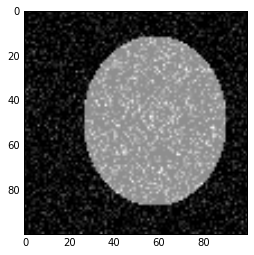

In [27]:
N = np.int_(X.shape[0] * np.random.rand())
plt.imshow(X[N,0], 'gray')
plt.show()

In [318]:
input = T.tensor4('input')

In [319]:
l1 = layers.InputLayer((None,1,100,100), input_var=input)
l2 = layers.Conv2DLayer(
    l1,
    8,
    (3,3)
)
l3 = layers.Conv2DLayer(
    l2,
    8,
    (3,3)
)
l4 = layers.Pool2DLayer(
    l3,
    (3,3)
)
l5 = layers.Conv2DLayer(
    l4,
    16,
    (3,3)
)
l6 = layers.Conv2DLayer(
    l5,
    16,
    (3,3)
)
l7 = layers.Pool2DLayer(
    l6,
    (3,3)
)
l8 = layers.DenseLayer(
    layers.dropout(l7, p=.2),
    100,
)
l9 = layers.DenseLayer(
    layers.dropout(l8, p=.2),
    100,
)
l10 = layers.DenseLayer(
    layers.dropout(l9, p=.2),
    2,
    nonlinearity=lasagne.nonlinearities.softmax
)

In [320]:
layers.set_all_param_values(l10, weights)

In [321]:
le1 = layers.Conv2DLayer(
    l7,
    16,
    (3,3)
)
le2 = layers.Conv2DLayer(
    le1,
    16,
    (3,3)
)
le3 = layers.Pool2DLayer(
    le2,
    (2,2)
)
l8 = layers.DenseLayer(
    layers.dropout(le3, p=.2),
    100
)
l9.input_layer = l8
l10.input_layer = l9

In [322]:
# pretrain
target = T.matrix('target')

def cross_ent(output, target):
    return - T.sum(target * T.log(output), axis=1).mean()

label1 = layers.get_output(l10, deterministic=False)
label2 = layers.get_output(l10, deterministic=True)

cost = cross_ent(label1, target)
cost2 = cross_ent(label2, target)

params = layers.get_all_params(l10)

grads = T.grad(cost, params)

updates = momentum(cost, params, lr=1e-2, momentum=.9)

train_fn = theano.function([input, target], cost, updates=updates)
test_fn = theano.function([input, target], cost2)

In [323]:
np.random.seed(1991)

N = np.int_(.95 * X.shape[0])
Xtrain, ytrain = X[:N], y[:N,-2:]
Xtest, ytest = X[N:], y[N:,-2:]

idx = np.arange(N)

epochs = 1000
batch_size=40

train_cost = []
test_cost = []

for epoch in range(epochs):
    batch_cost = []
    np.random.shuffle(idx)
    Xtrain, ytrain = Xtrain[idx], ytrain[idx]
    for i in tqdm(range(0,Xtrain.shape[0],batch_size)):
        Xbatch,ybatch = Xtrain[i*batch_size:(i+1)*batch_size], ytrain[i*batch_size:(i+1)*batch_size]
        if Xbatch.shape[0] > 0:
            err =  train_fn(Xbatch, ybatch)
            batch_cost.append(err)
    train_cost.append(np.mean(batch_cost))
    test_cost.append(test_fn(Xtest,ytest))
    print('Training error: %.4f, Test eror: %.4f' % (train_cost[epoch], test_cost[epoch]))

  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.8502, Test eror: 0.7042


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.7137, Test eror: 0.6512


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.7285, Test eror: 0.6036


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.6934, Test eror: 0.5575


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.7546, Test eror: 0.5144


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4952, Test eror: 0.4926


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.5061, Test eror: 0.4621


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4825, Test eror: 0.4185


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4508, Test eror: 0.4010


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4225, Test eror: 0.3991


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.5265, Test eror: 0.3762


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4842, Test eror: 0.3306


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4478, Test eror: 0.3488


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4297, Test eror: 0.3313


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4509, Test eror: 0.2876


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4286, Test eror: 0.3015


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3634, Test eror: 0.3049


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2864, Test eror: 0.2734


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2203, Test eror: 0.2424


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2191, Test eror: 0.2326


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3395, Test eror: 0.2325


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1934, Test eror: 0.2701


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1629, Test eror: 0.2725


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2408, Test eror: 0.3856


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3422, Test eror: 0.2098


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3235, Test eror: 0.2228


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2499, Test eror: 0.2208


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2057, Test eror: 0.1886


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1267, Test eror: 0.1776


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0552, Test eror: 0.1747


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2262, Test eror: 0.1859


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1758, Test eror: 0.2013


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2328, Test eror: 0.2246


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3631, Test eror: 0.2152


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2647, Test eror: 0.2019


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2375, Test eror: 0.2579


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2358, Test eror: 0.2383


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2443, Test eror: 0.1698


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1626, Test eror: 0.1545


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2443, Test eror: 0.1479


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1360, Test eror: 0.1578


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2137, Test eror: 0.1477


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2356, Test eror: 0.1385


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1529, Test eror: 0.1333


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1151, Test eror: 0.1290


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1761, Test eror: 0.1522


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0976, Test eror: 0.1978


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1585, Test eror: 0.1857


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0533, Test eror: 0.1584


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0977, Test eror: 0.1135


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0517, Test eror: 0.1155


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1610, Test eror: 0.1224


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0706, Test eror: 0.3041


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1236, Test eror: 0.4384


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4221, Test eror: 0.1768


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2863, Test eror: 0.5807


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.7161, Test eror: 0.2721


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4032, Test eror: 0.2002


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1122, Test eror: 0.6569


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4857, Test eror: 0.5148


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4391, Test eror: 0.1988


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1919, Test eror: 0.2548


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4453, Test eror: 0.3818


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4669, Test eror: 0.4576


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.7188, Test eror: 0.3736


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4035, Test eror: 0.2961


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3041, Test eror: 0.2704


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2988, Test eror: 0.2845


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2722, Test eror: 0.3082


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3693, Test eror: 0.2848


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1735, Test eror: 0.2524


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3646, Test eror: 0.1985


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1785, Test eror: 0.1690


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1785, Test eror: 0.1653


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2212, Test eror: 0.1710


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1868, Test eror: 0.1670


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1398, Test eror: 0.1480


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1060, Test eror: 0.1283


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0541, Test eror: 0.1447


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0632, Test eror: 0.1842


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.4045, Test eror: 0.1215


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0794, Test eror: 0.2261


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1580, Test eror: 0.3436


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2313, Test eror: 0.2529


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1642, Test eror: 0.1095


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1297, Test eror: 0.1712


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2827, Test eror: 0.0953


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1312, Test eror: 0.1046


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3357, Test eror: 0.1218


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1340, Test eror: 0.0962


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1192, Test eror: 0.0942


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1585, Test eror: 0.1466


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0809, Test eror: 0.2061


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1828, Test eror: 0.0984


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1490, Test eror: 0.0797


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0726, Test eror: 0.1055


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1646, Test eror: 0.1178


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1726, Test eror: 0.0844


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0524, Test eror: 0.0756


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0613, Test eror: 0.0746


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0814, Test eror: 0.0805


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2929, Test eror: 0.0844


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2536, Test eror: 0.0797


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0984, Test eror: 0.0785


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0734, Test eror: 0.0776


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0507, Test eror: 0.0757


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0889, Test eror: 0.0752


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1094, Test eror: 0.0756


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0607, Test eror: 0.0783


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0663, Test eror: 0.0819


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0605, Test eror: 0.0781


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1622, Test eror: 0.0680


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0743, Test eror: 0.0652


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0245, Test eror: 0.0650


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0341, Test eror: 0.0665


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0541, Test eror: 0.0647


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0071, Test eror: 0.0651


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0454, Test eror: 0.0666


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0054, Test eror: 0.0692


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0432, Test eror: 0.0720


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0648, Test eror: 0.0759


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1593, Test eror: 0.0635


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0020, Test eror: 0.0556


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0414, Test eror: 0.0527


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0118, Test eror: 0.0528


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0736, Test eror: 0.0412


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0480, Test eror: 0.0405


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0710, Test eror: 0.0385


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0078, Test eror: 0.0443


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0837, Test eror: 0.0379


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0242, Test eror: 0.0375


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0077, Test eror: 0.0503


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1430, Test eror: 0.0799


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1345, Test eror: 0.0535


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2346, Test eror: 0.0433


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0666, Test eror: 0.0610


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0164, Test eror: 0.0828


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2304, Test eror: 0.0782


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2380, Test eror: 0.0618


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0640, Test eror: 0.0739


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0466, Test eror: 0.1534


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2371, Test eror: 0.1152


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2829, Test eror: 0.0729


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1280, Test eror: 0.1256


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0900, Test eror: 0.2471


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.3070, Test eror: 0.1120


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2027, Test eror: 0.0764


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1248, Test eror: 0.1402


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2645, Test eror: 0.1883


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2647, Test eror: 0.1056


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2953, Test eror: 0.0965


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0297, Test eror: 0.1382


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2041, Test eror: 0.1951


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2422, Test eror: 0.1515


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1132, Test eror: 0.1218


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1036, Test eror: 0.1059


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0609, Test eror: 0.1071


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1453, Test eror: 0.1306


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0674, Test eror: 0.1497


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1287, Test eror: 0.1607


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2734, Test eror: 0.0985


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0480, Test eror: 0.0882


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0354, Test eror: 0.1062


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0991, Test eror: 0.1428


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0658, Test eror: 0.1840


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1489, Test eror: 0.1668


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1484, Test eror: 0.1001


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0431, Test eror: 0.0805


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0766, Test eror: 0.0805


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0295, Test eror: 0.0846


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0326, Test eror: 0.0881


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0211, Test eror: 0.0947


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0037, Test eror: 0.1035


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1907, Test eror: 0.0846


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0881, Test eror: 0.0807


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0483, Test eror: 0.1374


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2095, Test eror: 0.1596


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0661, Test eror: 0.0950


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0990, Test eror: 0.0644


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0259, Test eror: 0.0533


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0628, Test eror: 0.0508


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0405, Test eror: 0.0510


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0168, Test eror: 0.0519


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0191, Test eror: 0.0549


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0405, Test eror: 0.0552


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1052, Test eror: 0.0451


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1689, Test eror: 0.0421


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0444, Test eror: 0.0441


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0513, Test eror: 0.0546


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0591, Test eror: 0.0646


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0869, Test eror: 0.0529


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0841, Test eror: 0.0484


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0528, Test eror: 0.0460


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0337, Test eror: 0.0486


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0466, Test eror: 0.0531


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0804, Test eror: 0.0562


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0205, Test eror: 0.0593


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0603, Test eror: 0.0600


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0972, Test eror: 0.0614


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0385, Test eror: 0.0628


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0043, Test eror: 0.0646


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0312, Test eror: 0.0670


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0220, Test eror: 0.0696


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0162, Test eror: 0.0713


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0272, Test eror: 0.0728


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0468, Test eror: 0.0731


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0451, Test eror: 0.0736


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0488, Test eror: 0.0725


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0277, Test eror: 0.0714


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0205, Test eror: 0.0690


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0334, Test eror: 0.0633


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0421, Test eror: 0.0591


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0064, Test eror: 0.0559


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0104, Test eror: 0.0536


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0194, Test eror: 0.0513


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0020, Test eror: 0.0493


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0342, Test eror: 0.0474


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0089, Test eror: 0.0454


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0302, Test eror: 0.0357


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0025, Test eror: 0.0309


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0457, Test eror: 0.0289


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0714, Test eror: 0.0278


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0096, Test eror: 0.0271


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0371, Test eror: 0.0265


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0333, Test eror: 0.0260


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0115, Test eror: 0.0258


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0103, Test eror: 0.0258


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0096, Test eror: 0.0257


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0079, Test eror: 0.0258


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0057, Test eror: 0.0258


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0204, Test eror: 0.0257


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0317, Test eror: 0.0255


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0033, Test eror: 0.0254


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0003, Test eror: 0.0253


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0205, Test eror: 0.0252


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0184, Test eror: 0.0254


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0001, Test eror: 0.0258


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0163, Test eror: 0.0268


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0147, Test eror: 0.0283


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0067, Test eror: 0.0296


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0737, Test eror: 0.0304


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0480, Test eror: 0.0318


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0654, Test eror: 0.0295


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0161, Test eror: 0.0275


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0143, Test eror: 0.0257


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0065, Test eror: 0.0239


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0116, Test eror: 0.0224


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0449, Test eror: 0.0226


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0057, Test eror: 0.0228


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0033, Test eror: 0.0232


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0169, Test eror: 0.0233


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0098, Test eror: 0.0226


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0138, Test eror: 0.0229


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0233, Test eror: 0.0230


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0116, Test eror: 0.0221


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2713, Test eror: 0.0218


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0023, Test eror: 0.0215


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0031, Test eror: 0.0212


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0056, Test eror: 0.0212


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0332, Test eror: 0.0209


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0018, Test eror: 0.0209


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0058, Test eror: 0.0209


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0006, Test eror: 0.0212


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0317, Test eror: 0.0214


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0096, Test eror: 0.0215


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0060, Test eror: 0.0215


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0250, Test eror: 0.0217


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0035, Test eror: 0.0220


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0128, Test eror: 0.0222


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0239, Test eror: 0.0224


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0438, Test eror: 0.0225


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0012, Test eror: 0.0227


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0097, Test eror: 0.0227


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0082, Test eror: 0.0230


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0119, Test eror: 0.0225


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0194, Test eror: 0.0210


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0096, Test eror: 0.0194


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0496, Test eror: 0.0180


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0139, Test eror: 0.0169


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0012, Test eror: 0.0160


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0006, Test eror: 0.0152


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0173, Test eror: 0.0145


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0549, Test eror: 0.0137


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0042, Test eror: 0.0131


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0004, Test eror: 0.0126


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0084, Test eror: 0.0122


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0055, Test eror: 0.0119


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0207, Test eror: 0.0117


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0296, Test eror: 0.0117


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0127, Test eror: 0.0119


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0494, Test eror: 0.0136


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0173, Test eror: 0.0169


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0142, Test eror: 0.0212


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0209, Test eror: 0.0209


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0074, Test eror: 0.0207


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0024, Test eror: 0.0204


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0108, Test eror: 0.0202


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0148, Test eror: 0.0203


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0015, Test eror: 0.0205


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0275, Test eror: 0.0211


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0054, Test eror: 0.0216


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0150, Test eror: 0.0218


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0002, Test eror: 0.0219


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0005, Test eror: 0.0220


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0045, Test eror: 0.0219


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0174, Test eror: 0.0211


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0440, Test eror: 0.0210


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0355, Test eror: 0.0210


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0127, Test eror: 0.0206


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0095, Test eror: 0.0200


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0022, Test eror: 0.0194


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0022, Test eror: 0.0189


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0040, Test eror: 0.0186


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0015, Test eror: 0.0183


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0014, Test eror: 0.0177


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0232, Test eror: 0.0212


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0006, Test eror: 0.0251


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0003, Test eror: 0.0291


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0100, Test eror: 0.0329


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0078, Test eror: 0.0369


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0494, Test eror: 0.0157


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0008, Test eror: 0.0113


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0175, Test eror: 0.0097


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0170, Test eror: 0.0096


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0022, Test eror: 0.0148


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0085, Test eror: 0.0175


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1206, Test eror: 0.0080


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0090, Test eror: 0.0118


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0069, Test eror: 0.0215


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0186, Test eror: 0.0377


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.2638, Test eror: 0.0145


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0289, Test eror: 0.0289


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0349, Test eror: 0.1662


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0426, Test eror: 0.1407


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1515, Test eror: 0.0153


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0025, Test eror: 0.0208


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0013, Test eror: 0.0283


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0118, Test eror: 0.0346


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0343, Test eror: 0.0409


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0141, Test eror: 0.0448


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1295, Test eror: 0.0372


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0136, Test eror: 0.0327


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0208, Test eror: 0.0310


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0154, Test eror: 0.0298


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0137, Test eror: 0.0288


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0233, Test eror: 0.0289


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0071, Test eror: 0.0289


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0115, Test eror: 0.0289


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0120, Test eror: 0.0293


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0087, Test eror: 0.0302


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0045, Test eror: 0.0307


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0328, Test eror: 0.0304


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0790, Test eror: 0.0285


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0104, Test eror: 0.0268


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0084, Test eror: 0.0256


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0639, Test eror: 0.0239


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0305, Test eror: 0.0216


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0107, Test eror: 0.0194


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0075, Test eror: 0.0176


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0200, Test eror: 0.0160


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0094, Test eror: 0.0147


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0032, Test eror: 0.0140


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0083, Test eror: 0.0137


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0150, Test eror: 0.0137


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0009, Test eror: 0.0139


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0053, Test eror: 0.0143


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0015, Test eror: 0.0148


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0066, Test eror: 0.0153


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0029, Test eror: 0.0159


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0235, Test eror: 0.0155


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0209, Test eror: 0.0153


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0166, Test eror: 0.0151


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0068, Test eror: 0.0149


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0487, Test eror: 0.0131


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0174, Test eror: 0.0118


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0237, Test eror: 0.0113


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0004, Test eror: 0.0112


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0010, Test eror: 0.0115


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0057, Test eror: 0.0118


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1016, Test eror: 0.0121


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0124, Test eror: 0.0122


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0045, Test eror: 0.0123


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0006, Test eror: 0.0124


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0001, Test eror: 0.0124


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0085, Test eror: 0.0124


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0005, Test eror: 0.0125


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0009, Test eror: 0.0125


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0077, Test eror: 0.0125


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0042, Test eror: 0.0124


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0187, Test eror: 0.0123


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0275, Test eror: 0.0142


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0007, Test eror: 0.0167


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0349, Test eror: 0.0197


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0005, Test eror: 0.0233


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0145, Test eror: 0.0253


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0046, Test eror: 0.0271


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0014, Test eror: 0.0294


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0036, Test eror: 0.0326


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0005, Test eror: 0.0372


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0308, Test eror: 0.0263


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0886, Test eror: 0.0232


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0141, Test eror: 0.0220


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0090, Test eror: 0.0214


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0038, Test eror: 0.0208


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0022, Test eror: 0.0202


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0061, Test eror: 0.0199


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0440, Test eror: 0.0207


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.1288, Test eror: 0.0257


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0003, Test eror: 0.0308


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0001, Test eror: 0.0356


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0198, Test eror: 0.0405


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0111, Test eror: 0.0434


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0046, Test eror: 0.0462


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0017, Test eror: 0.0490


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0072, Test eror: 0.0516


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0049, Test eror: 0.0538


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0536, Test eror: 0.0522


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0583, Test eror: 0.0465


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0066, Test eror: 0.0416


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0362, Test eror: 0.0359


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0002, Test eror: 0.0306


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0030, Test eror: 0.0266


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0273, Test eror: 0.0247


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0251, Test eror: 0.0227


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0000, Test eror: 0.0213


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0002, Test eror: 0.0201


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0035, Test eror: 0.0192


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0362, Test eror: 0.0218


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0001, Test eror: 0.0253


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0004, Test eror: 0.0291


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0021, Test eror: 0.0334


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0178, Test eror: 0.0352


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0701, Test eror: 0.0331


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0289, Test eror: 0.0265


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0070, Test eror: 0.0223


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0019, Test eror: 0.0196


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0104, Test eror: 0.0172


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0085, Test eror: 0.0160


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0012, Test eror: 0.0150


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0028, Test eror: 0.0141


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0090, Test eror: 0.0144


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0019, Test eror: 0.0146


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0339, Test eror: 0.0133


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0042, Test eror: 0.0122


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0014, Test eror: 0.0113


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0411, Test eror: 0.0107


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0015, Test eror: 0.0102


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0029, Test eror: 0.0097


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0043, Test eror: 0.0096


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0132, Test eror: 0.0097


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0005, Test eror: 0.0097


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0072, Test eror: 0.0099


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0007, Test eror: 0.0102


  0%|          | 0/24 [00:00<?, ?it/s]

Training error: 0.0254, Test eror: 0.0110


KeyboardInterrupt: 

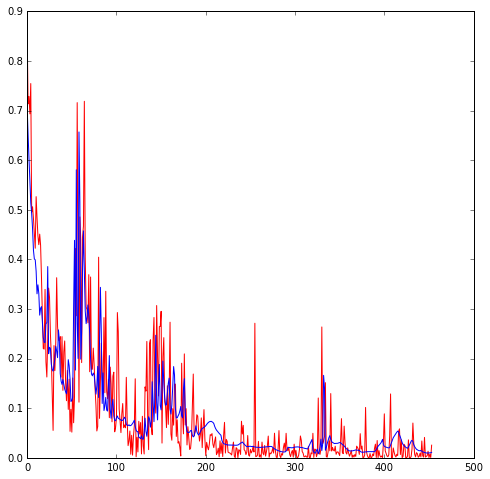

In [368]:
plt.figure(figsize=(8,8))
plt.plot(train_cost, 'r')
plt.plot(test_cost, 'b')
plt.show()

In [325]:
pred_fn = theano.function([input], label2)

In [326]:
preds = pred_fn(Xtest)

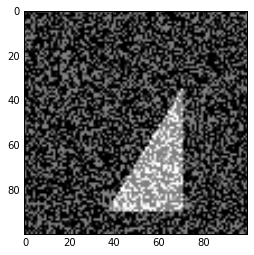

Triangle, confidence: 1.000


In [333]:
N = np.int_(Xtest.shape[0] * np.random.rand())
plt.imshow(Xtest[N,0], 'gray')
plt.show()

pred = np.argmax(preds[N])
if pred == 0:
    print('Circle, confidence: %.3f' % preds[N,0])
else:
    print('Triangle, confidence: %.3f' % preds[N,1])

In [335]:
act = layers.get_output(le3)
act_fn = theano.function([input], act)

In [336]:
act = act_fn(Xtest)

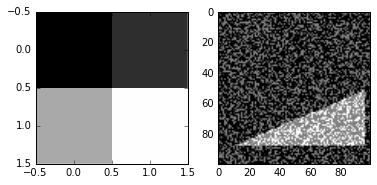

In [367]:
N = np.int_(Xtest.shape[0] * np.random.rand())
plt.subplot(1,2,1)
plt.imshow(act[N].mean(axis=0), 'gray', interpolation='None')
plt.subplot(1,2,2)
plt.imshow(Xtest[N,0], 'gray')
plt.show()

In [369]:
weights = layers.get_all_param_values(l10)
weights = [np.copy(w) for w in weights]

In [370]:
with open('weights.pkl', 'wb') as f:
    pk.dump(weights, f)

In [ ]:
reload(layers)
reload(yolo)

In [ ]:
yl = yolo.YoloObjectDetector(net, (None,3,200,200), 3, (2,2), 2)

In [ ]:
yl.train(
    X,
    y,
    lr=1e-2
)

In [ ]:
pred_fn = theano.function([yl.input], yl.output)

In [ ]:
Xval,yval = gen_dataset(50)

In [ ]:
yval[:2]

In [ ]:
pred_fn(Xval[:2])